<a href="https://colab.research.google.com/github/hideOncodee/CNN-IC2023/blob/main/IC2023_MobileNetV1_Based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/Original.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
path = '/content/drive/MyDrive/test_batch.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
data_dir = '/content/Original'

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    batch_size=64,
    image_size=(256, 256),
    validation_split=0.3,
    subset='training',
    seed=123,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=64,
    image_size=(256, 256),
    shuffle=True,
    validation_split=0.3,
    subset='validation',
    seed=123,
)

Found 1219 files belonging to 2 classes.
Using 854 files for training.
Found 1219 files belonging to 2 classes.
Using 365 files for validation.


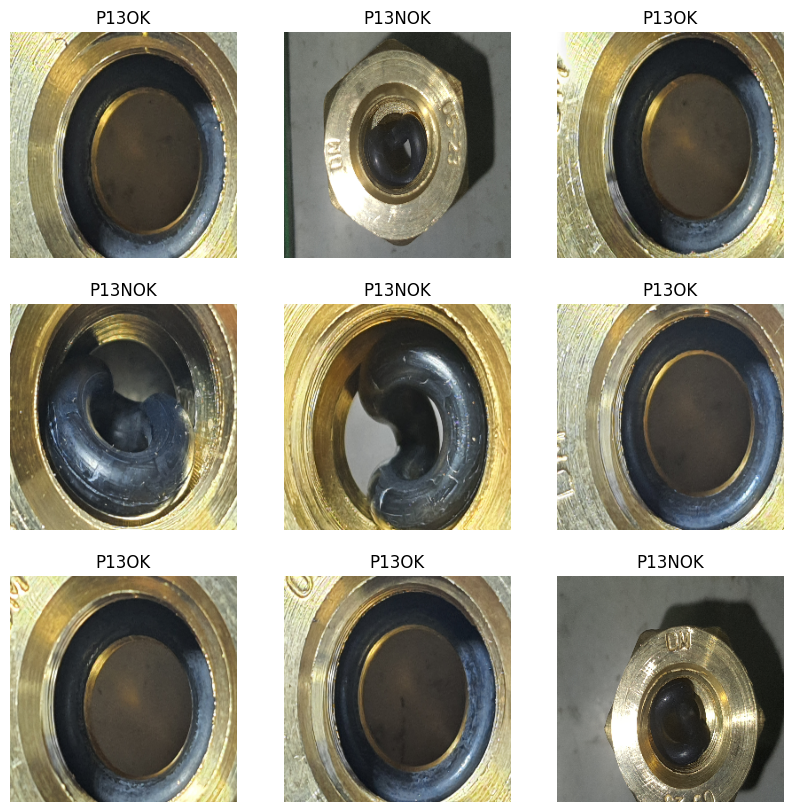

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical',
                               input_shape=(256, 256, 3)),
    tf.keras.layers.RandomRotation(0.3),
])

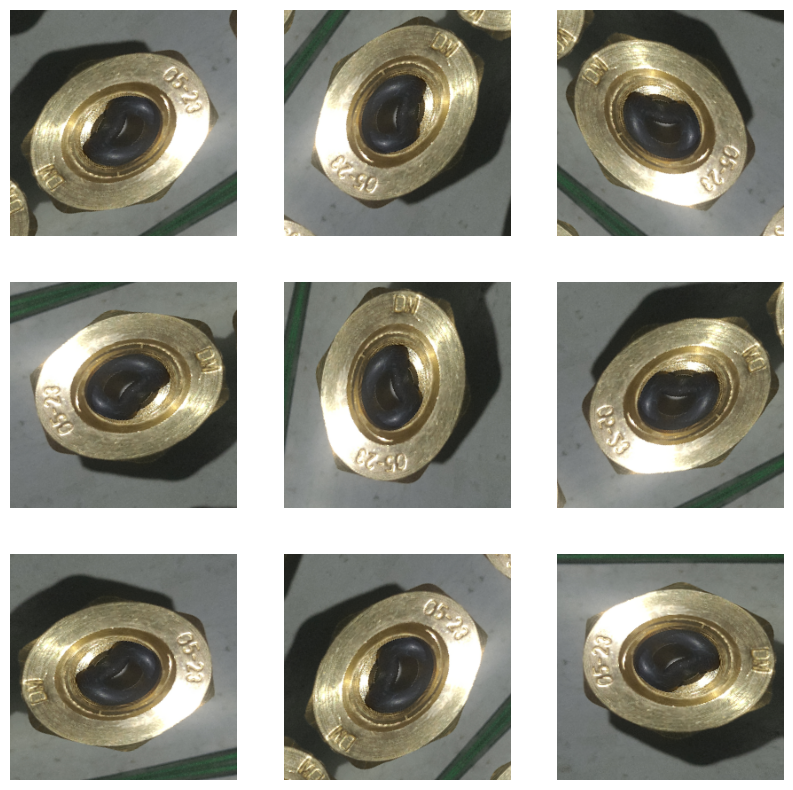

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
pre_process_input = tf.keras.applications.mobilenet.preprocess_input

In [ ]:
base_model = tf.keras.applications.MobileNet(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False
)

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 128, 128, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 128, 128, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 128, 128, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 128, 128, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 128, 128, 32

In [ ]:
inputs = tf.keras.layers.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = pre_process_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(units=1)(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 256, 256, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 256, 256, 3)       0         
 mbda)                                                           
                                                                 
 mobilenet_1.00_224 (Functi  (None, 8, 8, 1024)        3228864   
 onal)                                                           
                                                             

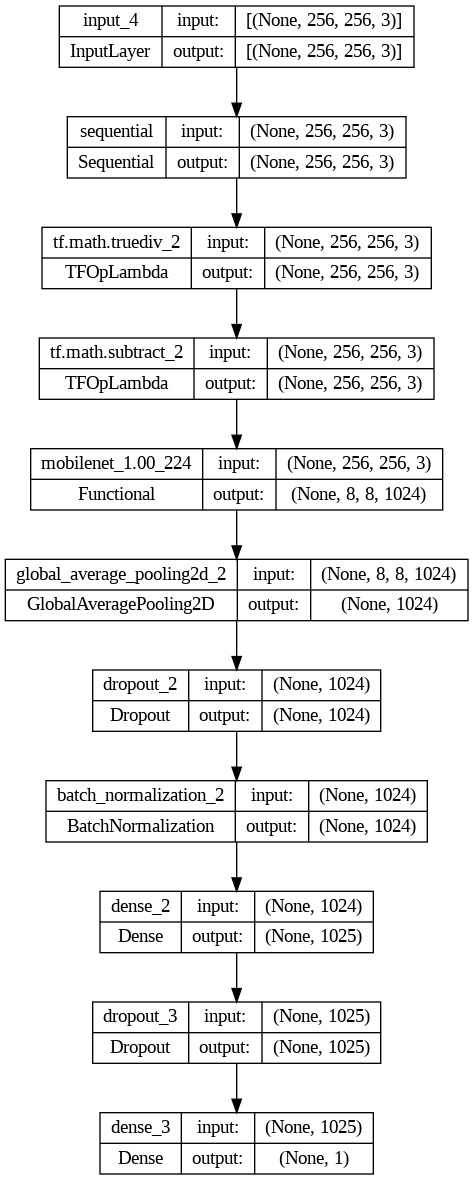

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
initial_epochs = 10

history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/10
14/14 [==============================] - 98s 2s/step - loss: 0.7305 - accuracy: 0.6265 - precision: 0.6543 - recall: 0.5655 - val_loss: 0.5847 - val_accuracy: 0.7143 - val_precision: 0.6646 - val_recall: 0.7786
Epoch 2/10
14/14 [==============================] - 2s 140ms/step - loss: 0.3906 - accuracy: 0.8126 - precision: 0.8481 - recall: 0.7701 - val_loss: 0.3504 - val_accuracy: 0.8970 - val_precision: 0.8303 - val_recall: 0.9786
Epoch 3/10
14/14 [==============================] - 2s 129ms/step - loss: 0.2294 - accuracy: 0.9063 - precision: 0.9216 - recall: 0.8920 - val_loss: 0.2206 - val_accuracy: 0.9402 - val_precision: 0.8910 - val_recall: 0.9929
Epoch 4/10
14/14 [==============================] - 2s 128ms/step - loss: 0.1505 - accuracy: 0.9485 - precision: 0.9600 - recall: 0.9379 - val_loss: 0.1425 - val_accuracy: 0.9767 - val_precision: 0.9524 - val_recall: 1.0000
Epoch 5/10
14/14 [==============================] - 2s 128ms/step - loss: 0.1132 - accuracy: 0.9672 - prec

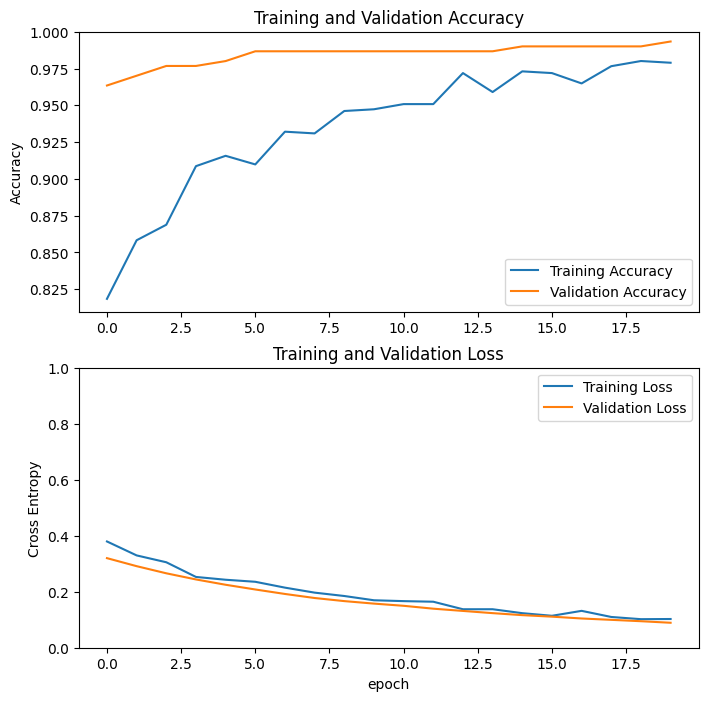

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 60

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
print('O número de camadas treináveis no modelo base é:', len(model.trainable_variables))

O número de camadas treináveis no modelo base é: 28


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(0.00001),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds)

Epoch 10/20
14/14 [==============================] - 12s 220ms/step - loss: 0.1688 - accuracy: 0.9461 - precision_1: 0.9687 - recall_1: 0.9241 - val_loss: 0.2258 - val_accuracy: 0.9668 - val_precision_1: 0.9333 - val_recall_1: 1.0000
Epoch 11/20
14/14 [==============================] - 2s 162ms/step - loss: 0.0633 - accuracy: 0.9941 - precision_1: 0.9909 - recall_1: 0.9977 - val_loss: 0.1779 - val_accuracy: 0.9834 - val_precision_1: 0.9655 - val_recall_1: 1.0000
Epoch 12/20
14/14 [==============================] - 2s 167ms/step - loss: 0.0413 - accuracy: 0.9965 - precision_1: 0.9977 - recall_1: 0.9954 - val_loss: 0.1273 - val_accuracy: 0.9934 - val_precision_1: 0.9859 - val_recall_1: 1.0000
Epoch 13/20
14/14 [==============================] - 3s 184ms/step - loss: 0.0211 - accuracy: 0.9988 - precision_1: 0.9977 - recall_1: 1.0000 - val_loss: 0.0732 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 14/20
14/14 [==============================] - 2s 167ms/step 

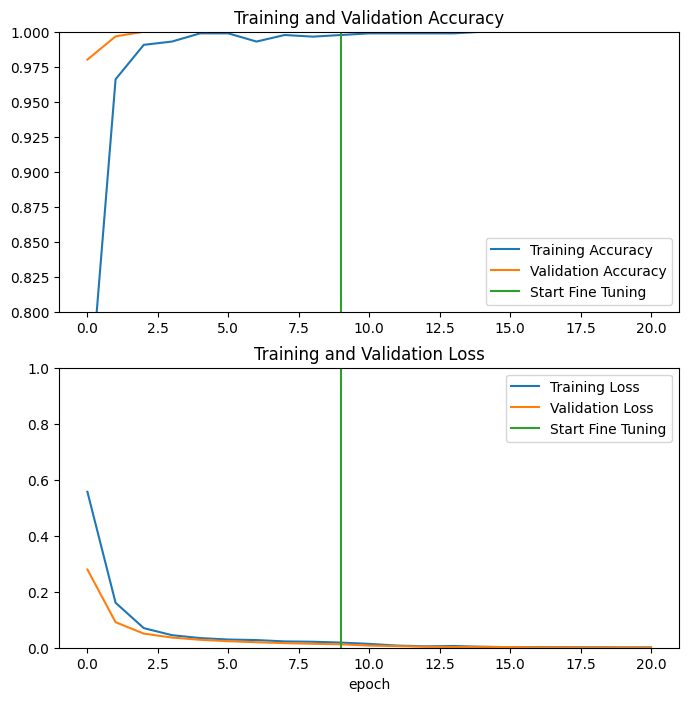

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test precision :', precision)
print('Test recall :', recall)

1/1 [==============================] - 26s 26s/step - loss: 0.0051 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000
Test accuracy : 1.0
Test precision : 1.0
Test recall : 1.0


Predictions:
 [0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 1
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0]
Labels:
 [0 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0]


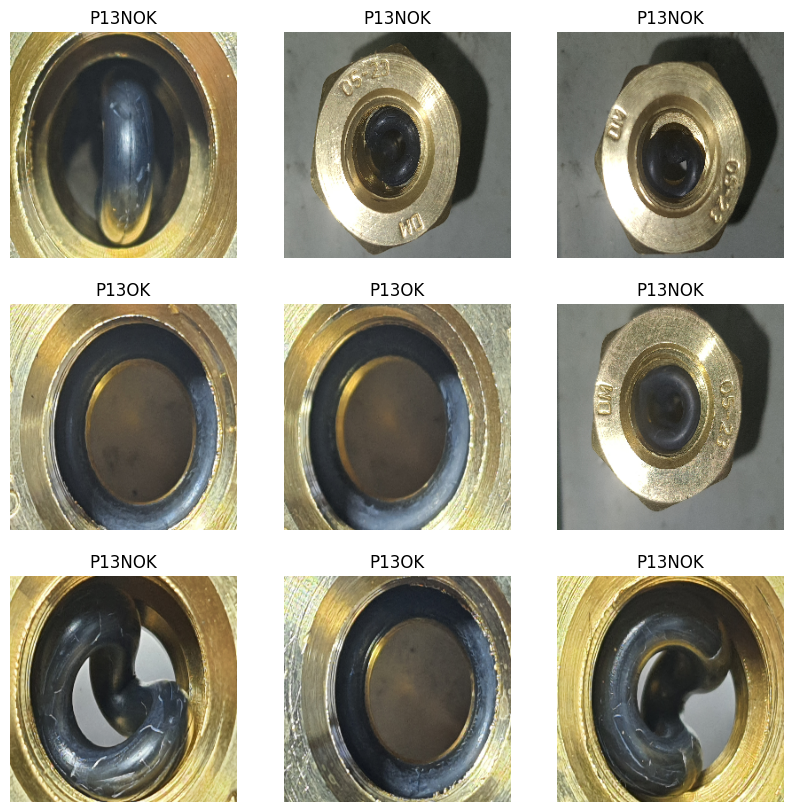

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
model_saved = save_model(model, '/content/weights.hdf5')

<ipython-input-49-c5122d7aeb50>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  model_saved = save_model(model, '/content/weights.hdf5')


In [ ]:
img = cv2.imread('/content/Original/P13OK/P13OK_150.jpg')
img = cv2.resize(img, (256,256))
img = img.reshape(-1, 256, 256, 3)
predict = model.predict(img)
predict = tf.math.sigmoid(predict)
print(predict)
if predict < 0.5:
  print('NOK')
else:
  print('OK')

1/1 [==============================] - 0s 36ms/step
tf.Tensor([[0.99991834]], shape=(1, 1), dtype=float32)
OK


In [ ]:
# Directory containing images batch
images_folder = '/content/test_batch'

# Array to store predictions from network
predictions_list = []

In [ ]:
for filename in os.listdir(images_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(images_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = img.reshape(-1, 256, 256, 3)
        predict = model.predict(img)
        predict = tf.math.sigmoid(predict)
        print(predict)

        if predict < 0.5:
            predict = 'NOK'
        else:
            predict = 'OK'

        predictions_list.append(predict)

# Print predictions
for filename, prediction in zip(os.listdir(images_folder), predictions_list):
    print(f"{filename}: {prediction}")

1/1 [==============================] - 0s 492ms/step
tf.Tensor([[0.64798754]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 20ms/step
tf.Tensor([[0.39700946]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 26ms/step
tf.Tensor([[0.77319545]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 19ms/step
tf.Tensor([[0.3128615]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 26ms/step
tf.Tensor([[0.7467147]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 20ms/step
tf.Tensor([[0.32988596]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 19ms/step
tf.Tensor([[0.35150406]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 20ms/step
tf.Tensor([[0.41955963]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 0s 19ms/step
tf.Tensor([[0.7188192]], shape=(1, 1), dtype=float32)
1/1 [==============================] - 